End Date for HDFC stock is 2021-02-24 00:00:00
Start Date for HDFC stock is 2001-02-27 00:00:00
Displaying results of DWT Decomposing!
Displaying results of ARMA MODELLING!


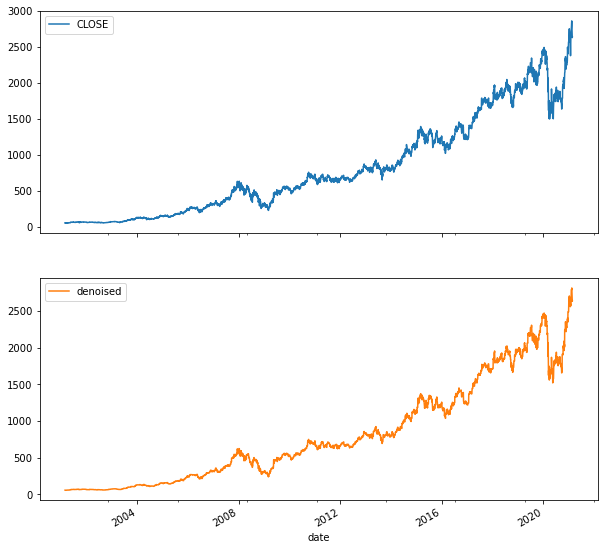

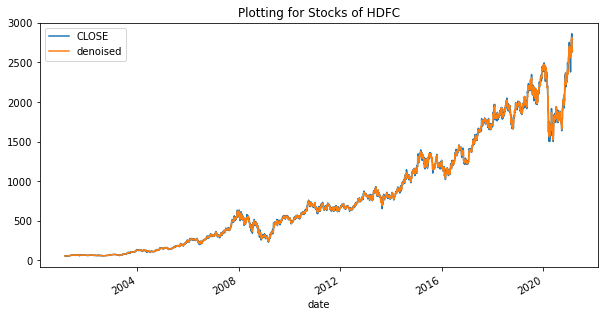

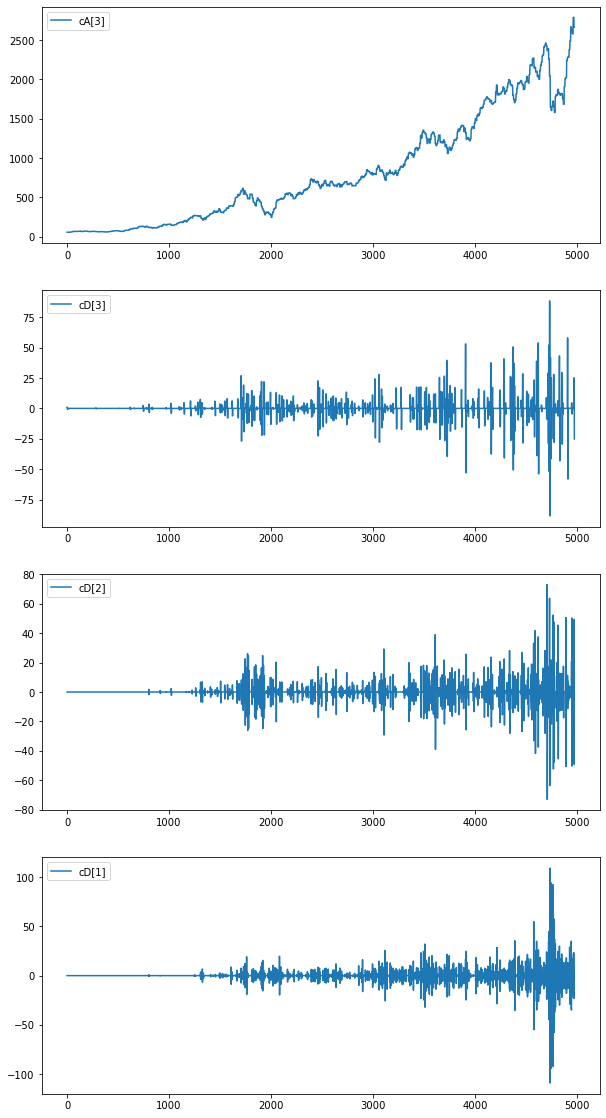

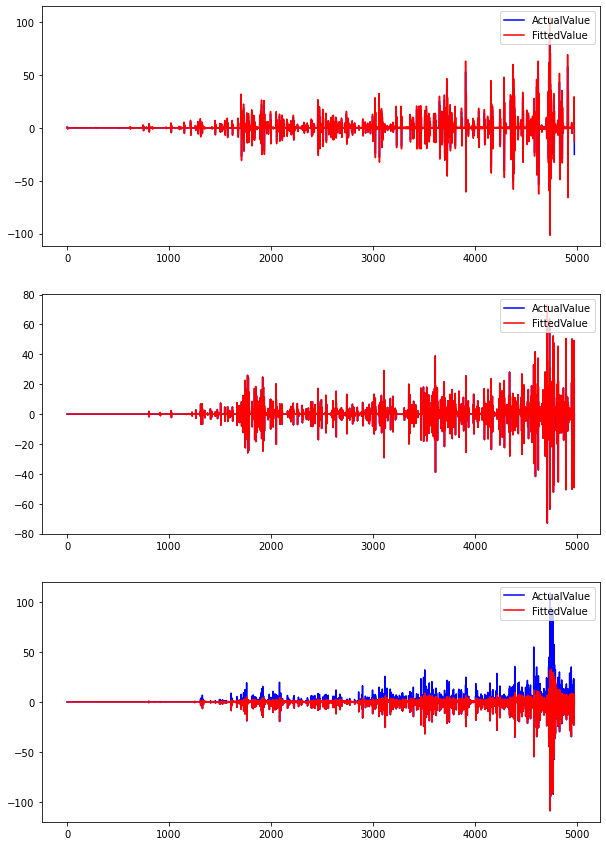

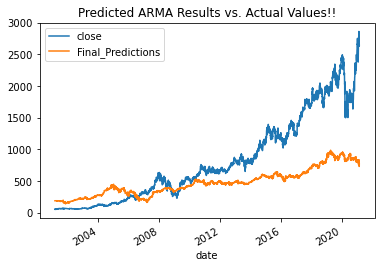

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
### Create the Stacked LSTM model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM
# import tensorflow as tf
import pywt
# from keras.layers import Dropout
import datetime

'''
Loading HDFC Dataset || Can be chnaged to any other Stock as per requirement.

1. HDFC Dataset
2. RELIANCE Dataset
3. SBIN Dataset
4. TATAMOTORS Dataset
'''


def load_dataset(path_to_dataset):
    stock_dataset = pd.read_csv(path_to_dataset)
    return stock_dataset

# Calling Load Dataset function

path_to_hdfc_dataset = 'HDFC.daily.csv'
hdfc_dataset = load_dataset(path_to_dataset= path_to_hdfc_dataset)

# print(hdfc_dataset.head())


'''
Applying Some preprocessing Steps:

1. Convert Column "t" which is a TIMESTAMP to the actual human readabale date and then fetch the ACTUAL DATE from it.
2. Convert the Column Names as below:
    a. o : open
    b. h : high
    c. l : low
    d. c : close
    
3. Fetch ONLY the "DATE" and "CLOSE" columns for further analysis
4. Sequentially, pring the Start Date and End Date for a particular Stock
'''


def preprocessing_stock_dataset(hdfc_dataset):
    hdfc_dataset['datetime'] = hdfc_dataset['t'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    hdfc_dataset = hdfc_dataset.loc[:,['symbol','o','h','l','c','datetime']].rename(columns = {'o':'open','h':'high','l':'low','c':'close'})
    stock_name = hdfc_dataset['symbol'].unique().tolist()[0]
    hdfc_dataset['datetime'] = pd.to_datetime(hdfc_dataset['datetime'])
    hdfc_dataset['time'] = hdfc_dataset['datetime'].dt.strftime('%H:%M:%S')
    hdfc_dataset['date'] = pd.to_datetime(hdfc_dataset['datetime'].dt.date) 
    main_data = hdfc_dataset.loc[:,['date','close']]
    
    
    # Let's look at the max and min date for the data
    max_date = main_data['date'].max()
    min_date = main_data['date'].min()
    main_data = main_data.set_index('date')
    print('End Date for {} stock is {}'.format(stock_name,max_date))
    print('Start Date for {} stock is {}'.format(stock_name,min_date))
    
    return main_data,stock_name

# Calling the Preprocessing Function

hdfc_data,stock_name = preprocessing_stock_dataset(hdfc_dataset)
# print(hdfc_data.head())


'''
Now, we will attempt a 3 Level Decomposition for our CLOSE PRICE Column.

Result from this function:

1. Aprroximation Series
2. Decomposition Series
3. Plot comparing **Original Series vs. Approximation Series vs. Decomposed Series**
'''


def DWT_decompose(index_list,stock_name, wavefunc='haar', lv=3, m=1, n=3, plot=False):
    
    '''
    DWT_decompose: Wavelet Transformation Function
    index_list: Input Sequence;
    stock_name: current stock name
    lv: Decomposing Level；
 
    wavefunc: Function of Wavelet, 'db4' default；
    
    m, n: Level of Threshold Processing
   
    '''
   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
        plt.title('Plotting for Stocks of {}'.format(stock_name))
   
    return coeff

# Calling decompose function
series_to_pass = hdfc_data['close']
coefficients = DWT_decompose(series_to_pass,stock_name,plot=True)

# Plotting the Coefficinets in an expanded manner.
def plot_figures(coefficients):
    print('Displaying results of DWT Decomposing!')
    fig, ax =  plt.subplots(len(coefficients), 1, figsize=(10, 20))
    for i in range(len(coefficients)):
        if i == 0:
            ax[i].plot(coefficients[i], label = 'cA[%.0f]'%(len(coefficients)-i-1))
            ax[i].legend(loc = 'best')
        else:
            ax[i].plot(coefficients[i], label = 'cD[%.0f]'%(len(coefficients)-i))
            ax[i].legend(loc = 'best')

plot_figures(coefficients)

'''
Now, the decomposed series is supposed to MODEL using ARMA Modelling

'''
def AR_MA(coeff):
    
    '''
    AR_MA:  Autoregressive Moving Average Function
    
    coeff:  Input sequence disposed by WT (Wavelet Transformation Function)
    
    '''
    
    warnings.filterwarnings('ignore')
    order, model, results = [], [], []

    for i in range(1, len(coeff)):
        order.append(sm.tsa.arma_order_select_ic(coeff[i], ic='aic')['aic_min_order'])   # Select (p, q) by AIC criterion 
        model.append(ARMA(coeff[i], order=order[i-1]))
    
    for i in range(len(model)):
        new_order = list(order[i])
        while True:
            try:
                results.append(model[i].fit())
                
            except ValueError:                                     # Further determinte the appropriate (p, q) for the model
                new_order[1] = np.max((0, new_order[1]-1))
                model[i] = ARMA(coeff[i+1], order=new_order)         

            if len(results)>= i+1:
                break                
    
    return results

# Calling the ARMA Model function
results = AR_MA(coefficients)

# Displaying the results of the ARMA Modelling

print('Displaying results of ARMA MODELLING!')
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coefficients[i+1], 'blue', label='ActualValue')
    plt.legend(loc='upper right')
    plt.plot(results[i].fittedvalues, 'red', label='FittedValue')
    plt.legend(loc='upper right')

'''

But ARMA model only models the DECOMPOSITONED Components. So we need another modelling technique to model 
the APPROXIMATION coefficients also.

'''
def final_results_func(coefficients,results,hdfc_data):
    hdfc_data['cA3'] = coefficients[0]
    hdfc_data['cD3'] = coefficients[1]
    hdfc_data['cD2'] = coefficients[2]
    hdfc_data['cD1'] = coefficients[3]

    hdfc_data['cD3_pred'] = results[0].fittedvalues
    hdfc_data['cD2_pred'] = results[1].fittedvalues
    hdfc_data['cD1_pred'] = results[2].fittedvalues

    n = len(hdfc_data)
    hdfc_data['Final_Predictions'] = pywt.upcoef('a', hdfc_data.cA3, 'haar', take=n) + pywt.upcoef('d', hdfc_data.cD3_pred, 'haar', take=n) + pywt.upcoef('d', hdfc_data.cD2_pred, 'haar', take=n) + pywt.upcoef('d', hdfc_data.cD1_pred, 'haar', take=n)

    hdfc_data.loc[:,['close','Final_Predictions']].plot();
    plt.title('Predicted ARMA Results vs. Actual Values!!');
    
    return hdfc_data

final_stock_results = final_results_func(coefficients,results,hdfc_data)
    


In [2]:
final_stock_results.head(10)

,close,cA3,cD3,cD2,cD1,cD3_pred,cD2_pred,cD1_pred,Final_Predictions
date,,,,,,,,,
2001-02-27,59.13,56.13625,0.825532,0.0,0.0,0.005851,0.002568,0.000556,190.277992
2001-02-28,59.35,56.13625,0.825532,0.0,0.0,0.480369,0.002048,0.000932,190.214400
2001-03-01,59.85,56.13625,0.825532,0.0,0.0,0.386902,0.003406,0.001109,190.261842
2001-03-02,55.61,56.13625,0.825532,0.0,0.0,0.176949,0.002584,0.001448,190.230549
2001-03-05,52.62,56.13625,-0.825532,0.0,0.0,-0.170831,0.003631,0.001595,190.245497
2001-03-07,54.41,56.13625,-0.825532,0.0,0.0,-0.720034,0.002584,0.001952,190.246895
2001-03-08,54.08,56.13625,-0.825532,0.0,0.0,-0.947687,0.003163,0.002078,190.262339
2001-03-09,54.04,56.13625,-0.825532,0.0,0.0,-0.754420,0.002584,0.002447,190.230052
2001-03-12,54.51,56.56000,0.000000,0.0,0.0,0.384122,0.002984,0.002559,190.277918


In [8]:
from sklearn.metrics import mean_squared_error
y_true = hdfc_data.close
y_pred = hdfc_data.Final_Predictions
rmse = mean_squared_error(y_true, y_pred)
print('RMSE: {}'.format(round(rmse,2)))

RMSE: 348571.83


# Thank You!